In [0]:
!pip install torch

In [0]:
import torch
import random
import numpy as np
import pandas as pd
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
from google.colab import drive
path = '/content/drive/My Drive/dataset'

In [0]:
!ls '/content/drive/My Drive/dataset'

test  train


In [0]:
import torch.nn as nn
class PhysioNet(nn.Module):

    def __init__(self):
        super(PhysioNet, self).__init__()

        self.batch_norm0 = torch.nn.BatchNorm2d(1)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(5,4), padding=1, stride=1)
        self.act1 = torch.nn.LeakyReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(4)
        #self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(5,3), padding=1, stride=1)
        self.act2 = torch.nn.LeakyReLU()

        self.conv3 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5,3), padding=1, stride=1)
        self.act3 = torch.nn.LeakyReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(16)

        self.conv4 = torch.nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(7,3), padding=1, stride=1)
        self.act4 = torch.nn.LeakyReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(20)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = torch.nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(4,3), padding=1, stride=1)
        self.act5 = torch.nn.LeakyReLU()
        self.batch_norm4 = torch.nn.BatchNorm2d(30)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(13*5 * 30, 100)
        self.act4 = torch.nn.LeakyReLU()
        
        self.fc2 = torch.nn.Linear(100, 50)
        self.act5 = torch.nn.LeakyReLU()

        self.fc3 = torch.nn.Linear(50, 20)
        self.act6 = torch.nn.LeakyReLU()
        
        self.fc4 = torch.nn.Linear(20, 1)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)

        #x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm2(x)

        x = self.conv4(x)
        x = self.act4(x)
        x = self.batch_norm3(x)
        x = self.pool1(x)

        x = self.conv5(x)
        x = self.act5(x)
        x = self.batch_norm4(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.fc3(x)
        x = self.act5(x)
        x = self.fc4(x)
        return x

In [0]:
from torchsummary import summary
import sklearn.preprocessing as preprocessing
physionet = PhysioNet()
summary(physionet, (1, 64, 21))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 1, 64, 21]               2
            Conv2d-2            [-1, 4, 62, 20]              84
         LeakyReLU-3            [-1, 4, 62, 20]               0
       BatchNorm2d-4            [-1, 4, 62, 20]               8
            Conv2d-5            [-1, 8, 60, 20]             488
         LeakyReLU-6            [-1, 8, 60, 20]               0
            Conv2d-7           [-1, 16, 58, 20]           1,936
         LeakyReLU-8           [-1, 16, 58, 20]               0
       BatchNorm2d-9           [-1, 16, 58, 20]              32
           Conv2d-10           [-1, 20, 54, 20]           6,740
        LeakyReLU-11           [-1, 20, 54, 20]               0
      BatchNorm2d-12           [-1, 20, 54, 20]              40
        MaxPool2d-13           [-1, 20, 27, 10]               0
           Conv2d-14           [-1, 30,

In [0]:
Y_train = pd.read_csv("/content/drive/My Drive/dataset/train/y.csv", delimiter=";")
Y_train = np.array(Y_train.drop(["0.5010000000000012"],axis=1))
Y_train[0].item() < 5

False

In [0]:
good_y_train = []
good_train_index = []
for i in range(len(Y_train)):
  if (Y_train[i].item() > 1 and Y_train[i].item() < 100):
    good_y_train.append(Y_train[i].item())
    good_train_index.append(i)
good_y_train = np.array(good_y_train)
print(good_y_train)
good_y_train =  good_y_train / np.linalg.norm(good_y_train)
#good_y_train = preprocessing.normalize(good_y_train, norm = 'l1')
good_y_train = torch.tensor(good_y_train.reshape(-1,1))
print(good_y_train)

[59.74662354 36.68359362 17.79359431 ... 20.08444291 16.77621435
 31.34796238]
tensor([[0.0655],
        [0.0402],
        [0.0195],
        ...,
        [0.0220],
        [0.0184],
        [0.0344]], dtype=torch.float64)


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
physionet = physionet.to(device)
#for param in physionet.parameters():
#    param.requires_grad = False

In [0]:
#loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(physionet.parameters(), lr=1.0e-3)
def loss(pred, target):
    squares = (pred - target) ** 2
    return squares.mean()

In [0]:
y_test = pd.read_csv("/content/drive/My Drive/dataset/test/y.csv", delimiter=";")
y_test = np.array(y_test.drop(["0.7650000000001"],axis=1))
#y_test = preprocessing.normalize(y_test, norm = 'l1')
good_y_test = []
good_test_index = []

for i in range(len(y_test)):
  if (y_test[i].item() > 1 or y_test[i].item() < 100):
    good_test_index.append(i)
    good_y_test.append(y_test[i].item())

good_y_test = np.array(good_y_test)
good_y_test =  good_y_test / np.linalg.norm(good_y_test)
good_y_test = torch.tensor(good_y_test.reshape(-1,1))

x_test = []
for i in good_test_index:
  x = pd.read_csv("/content/drive/My Drive/dataset/test/{}.csv".format(i), delimiter=";")
  x = np.array(x)[:-1]
  x = np.delete(x.reshape(64,24),23,1)
  x = np.delete(x.reshape(64,23),22,1)
  x = np.delete(x.reshape(64,22),21,1)
  x = preprocessing.normalize(x, norm = 'l2')
  x_test.append(x)
x_test = torch.tensor(x_test)

In [0]:
x_train = []
for file in good_train_index:
  x = np.array(pd.read_csv("/content/drive/My Drive/dataset/train/{}.csv".format(file), delimiter=";"))[:-1]
  x = np.delete(x.reshape(64,24),23,1)
  x = np.delete(x.reshape(64,23),22,1)
  x = np.delete(x.reshape(64,22),21,1)
  x = preprocessing.normalize(x, norm = 'l2')
  x_train.append(x)

x_train = torch.tensor(x_train)

In [0]:
test_accuracy_history = []
test_loss_history = []


len_x_train = len(x_train)
batch_size = 100
for epoch in range(50):
    order = np.random.permutation(len_x_train)
    for start_index in range(0, len_x_train, batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]

        x_batch = x_train[batch_indexes].to(device)
        y_batch = good_y_train[batch_indexes].to(device)

        preds = physionet.forward(x_batch.unsqueeze(1).float())
        loss_value = loss(preds.float(),y_batch.float())
        loss_value.backward()
        
        optimizer.step()
    
    test_preds = physionet.forward(x_test.unsqueeze(1).float())
    loss_ac = loss(test_preds.float(), good_y_test.float())
    test_loss_history.append(loss_ac)#.data.cpu())
    
    print('{}\t|\t{:10.8f}}'.format(epoch, loss_ac))

0	|	0.00241920	|	0.99758083
1	|	0.00205316	|	0.99794686
2	|	0.00207724	|	0.99792278
3	|	0.00209959	|	0.99790043
4	|	0.00213038	|	0.99786961
5	|	0.00211914	|	0.99788088
6	|	0.00210858	|	0.99789143
7	|	0.00217029	|	0.99782974
8	|	0.00225947	|	0.99774051
9	|	0.00226387	|	0.99773616
10	|	0.00235813	|	0.99764186
11	|	0.00214054	|	0.99785948
12	|	0.00240329	|	0.99759668
13	|	0.00222636	|	0.99777365
14	|	0.00216542	|	0.99783456
15	|	0.00246974	|	0.99753028
16	|	0.00217951	|	0.99782050
17	|	0.00218796	|	0.99781203
18	|	0.00226830	|	0.99773169
19	|	0.00229373	|	0.99770629
20	|	0.00229387	|	0.99770612
21	|	0.00217052	|	0.99782950
22	|	0.00219401	|	0.99780601
23	|	0.00233199	|	0.99766803
24	|	0.00215273	|	0.99784726
25	|	0.00217172	|	0.99782830
26	|	0.00206901	|	0.99793100
27	|	0.00216128	|	0.99783874
28	|	0.00221078	|	0.99778920
29	|	0.00223876	|	0.99776125
30	|	0.00219085	|	0.99780917
31	|	0.00216995	|	0.99783003
32	|	0.00221377	|	0.99778622
33	|	0.00211612	|	0.99788386
34	|	0.00217826	|	0.9978

Text(0, 0.5, '$y$')

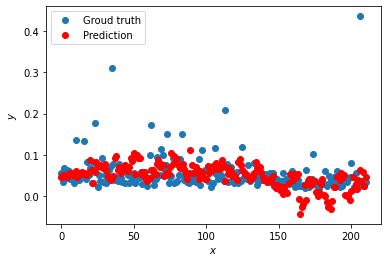

In [0]:
import matplotlib.pyplot as plt
x = physionet.forward(x_test.unsqueeze(1).float())
plt.plot(good_y_test.numpy(), 'o', label='Groud truth')
plt.plot(x.data.numpy(), 'o', c='r', label='Prediction');
plt.legend(loc='upper left')
plt.xlabel('$x$')
plt.ylabel('$y$')

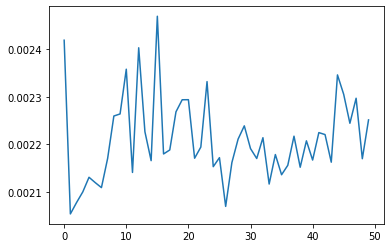

In [0]:
plt.plot(test_loss_history)

In [0]:
accuracy = np.ones(len(test_loss_history)) - test_loss_history

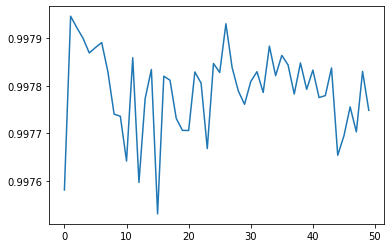

In [0]:
plt.plot(accuracy)